In [ ]:
#Cell 1:Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import warnings
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.dates as mdates
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import pickle

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [ ]:
#Cell 2:Load the data from CSV
csv_file_path = r"C:\Users\User\Downloads\UMHackathon2025\data\cryptoquant_btc-exchange-flows-in-house-flow_window_block_exchange_all_exchange_2020-04-09_to_2025-05-09.csv"

print(f"Reading data from CSV file: {csv_file_path}")

Reading data from CSV file: C:\Users\User\Downloads\UMHackathon2025\data\cryptoquant_btc-exchange-flows-in-house-flow_window_block_exchange_all_exchange_2020-04-09_to_2025-05-09.csv


In [ ]:
#Cell 3:Process the CSV data
try:
    df = pd.read_csv(csv_file_path)
    
    print("Successfully loaded CSV data")
    print("Data shape:", df.shape)
    print("Columns:", df.columns.tolist())
    
    if 'ts' in df.columns:
        df['datetime'] = pd.to_datetime(df['ts'], unit='ms')
   
    
    print("First few rows:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading CSV file: {e}")

   

Successfully loaded CSV data
Data shape: (266616, 6)
Columns: ['start_time', 'blockheight', 'datetime', 'flow_mean', 'flow_total', 'transactions_count_flow']
Found potential timestamp columns: ['start_time']
First few rows:
      start_time  blockheight            datetime  flow_mean   flow_total  \
0  1586391082000       625047 2020-04-09 00:11:22  17.346167  2220.309385   
1  1586391445000       625048 2020-04-09 00:17:25  10.060584   352.120455   
2  1586391552000       625049 2020-04-09 00:19:12   4.744710   151.830706   
3  1586391660000       625050 2020-04-09 00:21:00  16.013458   288.242241   
4  1586392040000       625051 2020-04-09 00:27:20   9.521104   457.013011   

   transactions_count_flow  
0                      128  
1                       35  
2                       32  
3                       18  
4                       48  


In [ ]:
# Cell 4: Display data statistics and find features
print("\nBasic statistics:")
df.describe()


Basic statistics:


,start_time,blockheight,datetime,flow_mean,flow_total,transactions_count_flow
count,2.666160e+05,266616.000000,266616,266616.000000,266616.000000,266616.000000
mean,1.665509e+12,758388.945847,2022-10-11 17:30:16.137028352,24.932077,1508.839525,61.951676
min,1.586391e+12,625047.000000,2020-04-09 00:11:22,0.000000,0.000000,0.000000
25%,1.626701e+12,691723.750000,2021-07-19 13:17:55.750000128,5.855218,192.433294,25.000000
50%,1.665607e+12,758392.500000,2022-10-12 20:43:23.500000,11.941114,661.148574,52.000000
75%,1.704835e+12,825054.250000,2024-01-09 21:14:09,23.874185,1685.891649,86.000000
max,1.744256e+12,891722.000000,2025-04-10 03:28:04,8635.138618,294914.640137,3464.000000
std,4.553611e+10,76981.340337,NaN,84.255094,4371.129618,54.791327


In [ ]:
#Cell 5:Features
expected_features = ['flow_mean', 'flow_total', 'transactions_count_flow']
available_features = []

for feature in expected_features:
    if feature in df.columns:
        available_features.append(feature)
    else:
        for col in df.columns:
            if feature.lower() in col.lower():
                available_features.append(col)
                print(f"Using '{col}' as a substitute for '{feature}'")
                break

if len(available_features) < 3:
    print("Warning: Not all expected features are available in the dataset.")
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    feature_candidates = [col for col in numeric_cols if 'block' not in col.lower() and 'time' not in col.lower() and 'ts' != col]
    
    for col in feature_candidates:
        if col not in available_features and len(available_features) < 3:
            available_features.append(col)
            print(f"Adding '{col}' as an additional feature")

features = available_features
print(f"\nUsing features: {features}")


Using features: ['flow_mean', 'flow_total', 'transactions_count_flow']


In [ ]:
#Cell 6:Prepare data for analysis
df = df.sort_values('datetime').reset_index(drop=True)
print("\nMissing values in each column:")
print(df.isnull().sum())

df = df.fillna(method='ffill')


Missing values in each column:
start_time                 0
blockheight                0
datetime                   0
flow_mean                  0
flow_total                 0
transactions_count_flow    0
dtype: int64


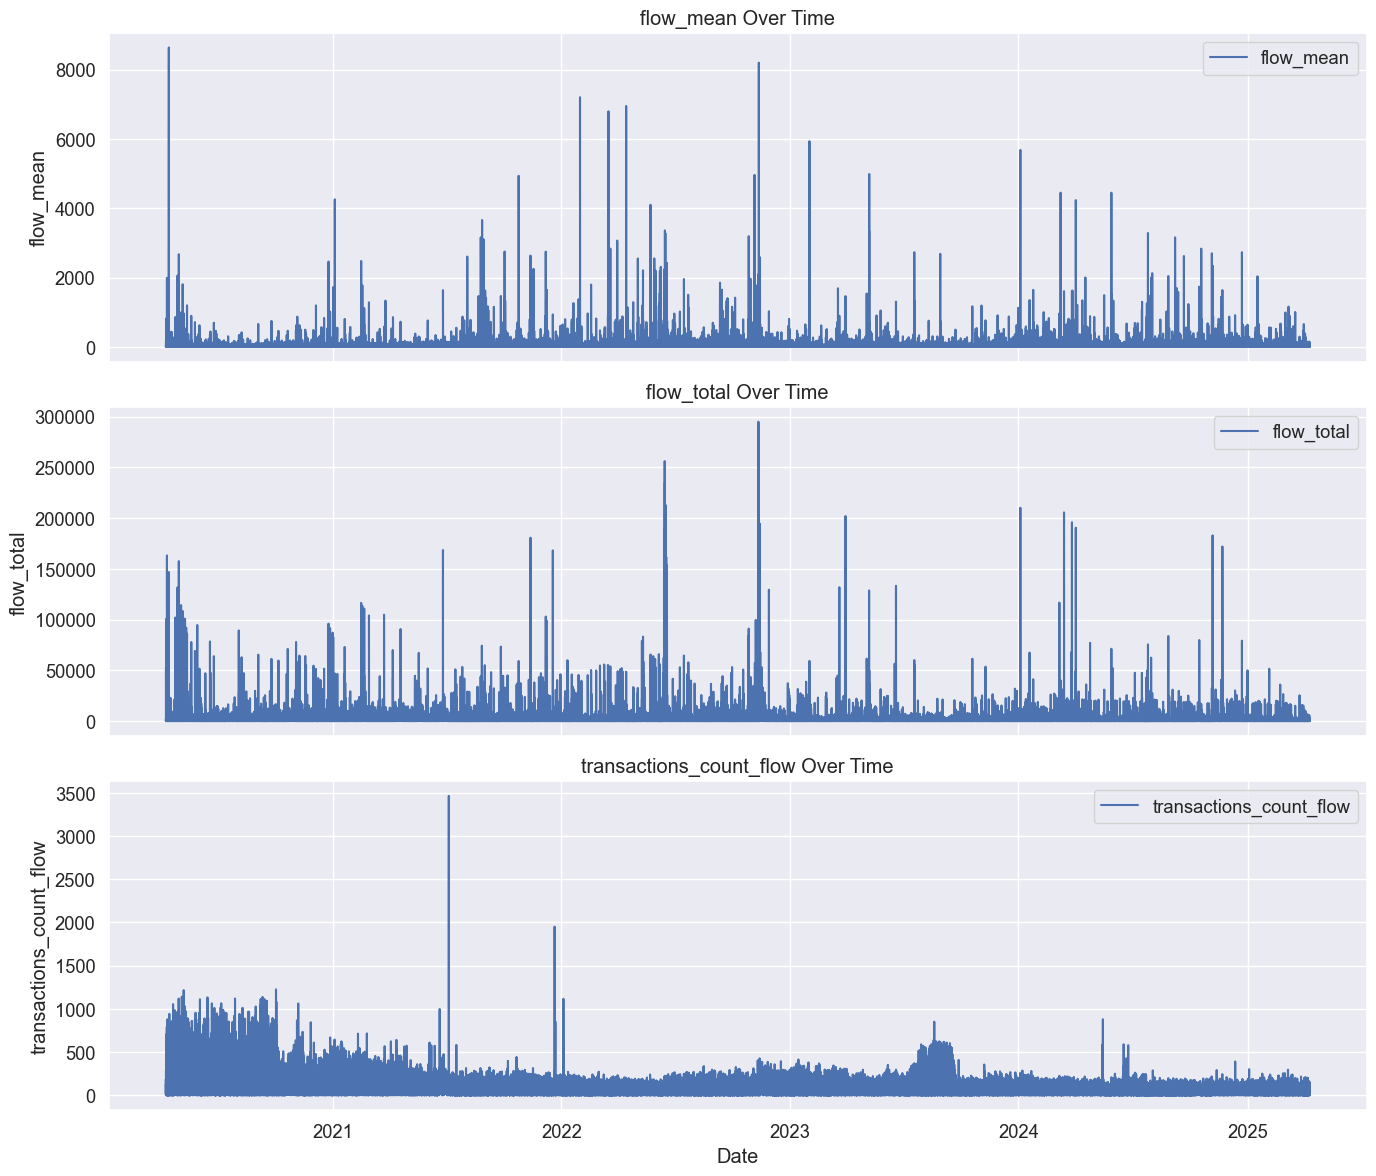

In [ ]:
#Cell 7:Plot time series data
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)

if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    axes[i].plot(df['datetime'], df[feature], label=feature)
    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_ylabel(feature)
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
#Cell 8:Prepare features and standardize
X = df[features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_df = pd.DataFrame(X_scaled, columns=features, index=df.index)


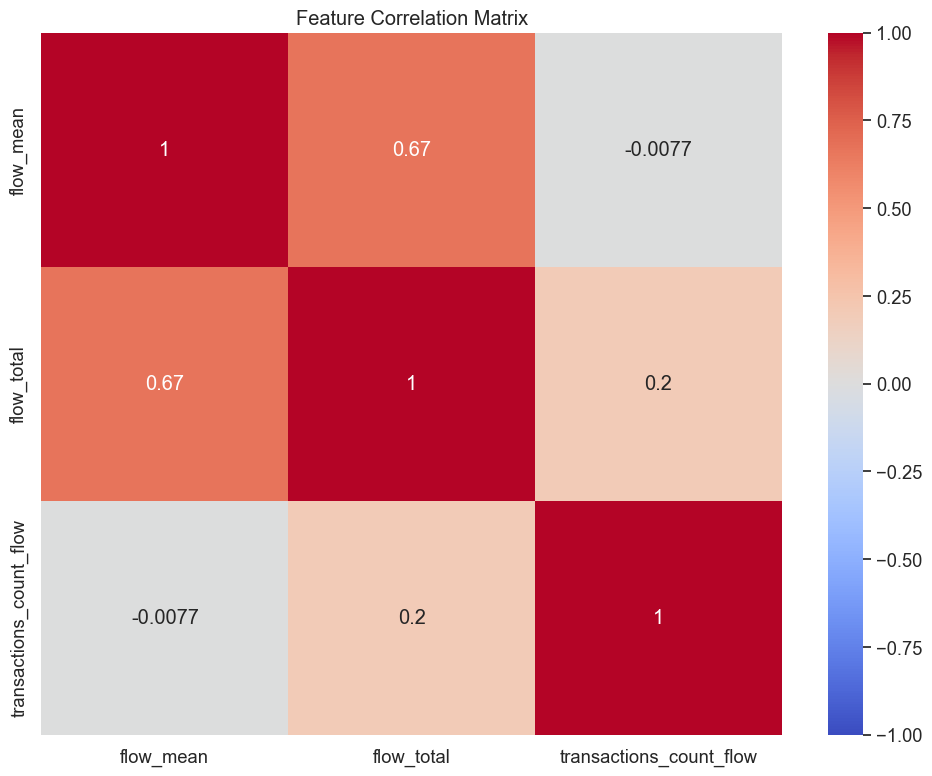

In [ ]:
#Cell 9:Plot feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

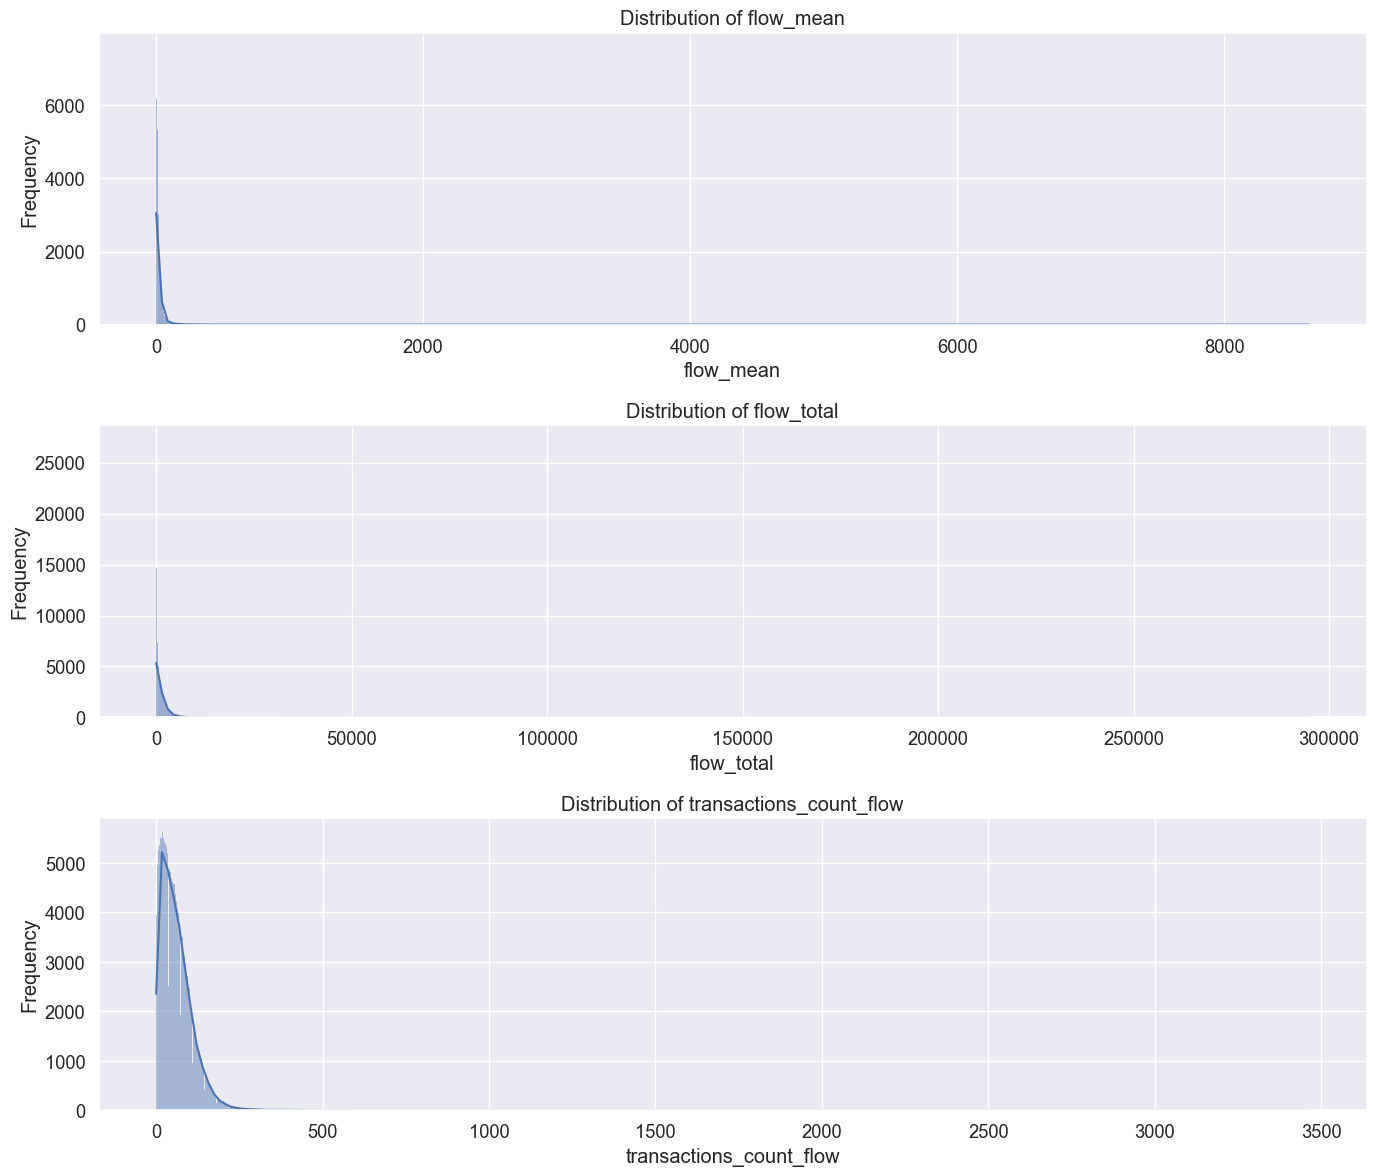

In [ ]:
#Cell 10:Plot feature distributions
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=False)
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
#Cell 11:Define function to find optimal number of states
def find_optimal_states(X_scaled, max_states=10):
    n_states_range = range(2, max_states + 1)
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    
    for n_states in n_states_range:
        print(f"Testing model with {n_states} states...")
        model = hmm.GaussianHMM(n_components=n_states, covariance_type='full', 
                               n_iter=100, random_state=42)
        model.fit(X_scaled)
        
        n_features = X_scaled.shape[1]
        n_params = n_states * n_states + n_states * n_features + n_states * n_features * (n_features + 1) // 2
        log_likelihood = model.score(X_scaled)
        bic = -2 * log_likelihood + n_params * np.log(X_scaled.shape[0])
        aic = -2 * log_likelihood + 2 * n_params
        
        bic_scores.append(bic)
        aic_scores.append(aic)
        hidden_states = model.predict(X_scaled)
        
        if n_states > 1:
            try:
                silhouette = silhouette_score(X_scaled, hidden_states)
                silhouette_scores.append(silhouette)
            except:
                silhouette_scores.append(np.nan)
        else:
            silhouette_scores.append(np.nan)
    
    plt.figure(figsize=(12, 8))
    plt.plot(n_states_range, bic_scores, 'o-', label='BIC')
    plt.plot(n_states_range, aic_scores, 's-', label='AIC')
    plt.xlabel('Number of States')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores for Different Numbers of States')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.plot(n_states_range, silhouette_scores, 'o-', label='Silhouette Score')
    plt.xlabel('Number of States')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of States')
    plt.grid(True)
    plt.show()
    
    optimal_n_states = n_states_range[np.argmin(bic_scores)]
    print(f"Optimal number of states based on BIC: {optimal_n_states}")
    
    return optimal_n_states


In [ ]:
#Cell 12:Optimal
optimal_n_states = 6

In [ ]:
#Cell 13:HMM model
model = hmm.GaussianHMM(n_components=optimal_n_states, 
                       covariance_type='full', 
                       n_iter=100, 
                       random_state=42)

model.fit(X_scaled)

hidden_states = model.predict(X_scaled)

df['regime'] = hidden_states

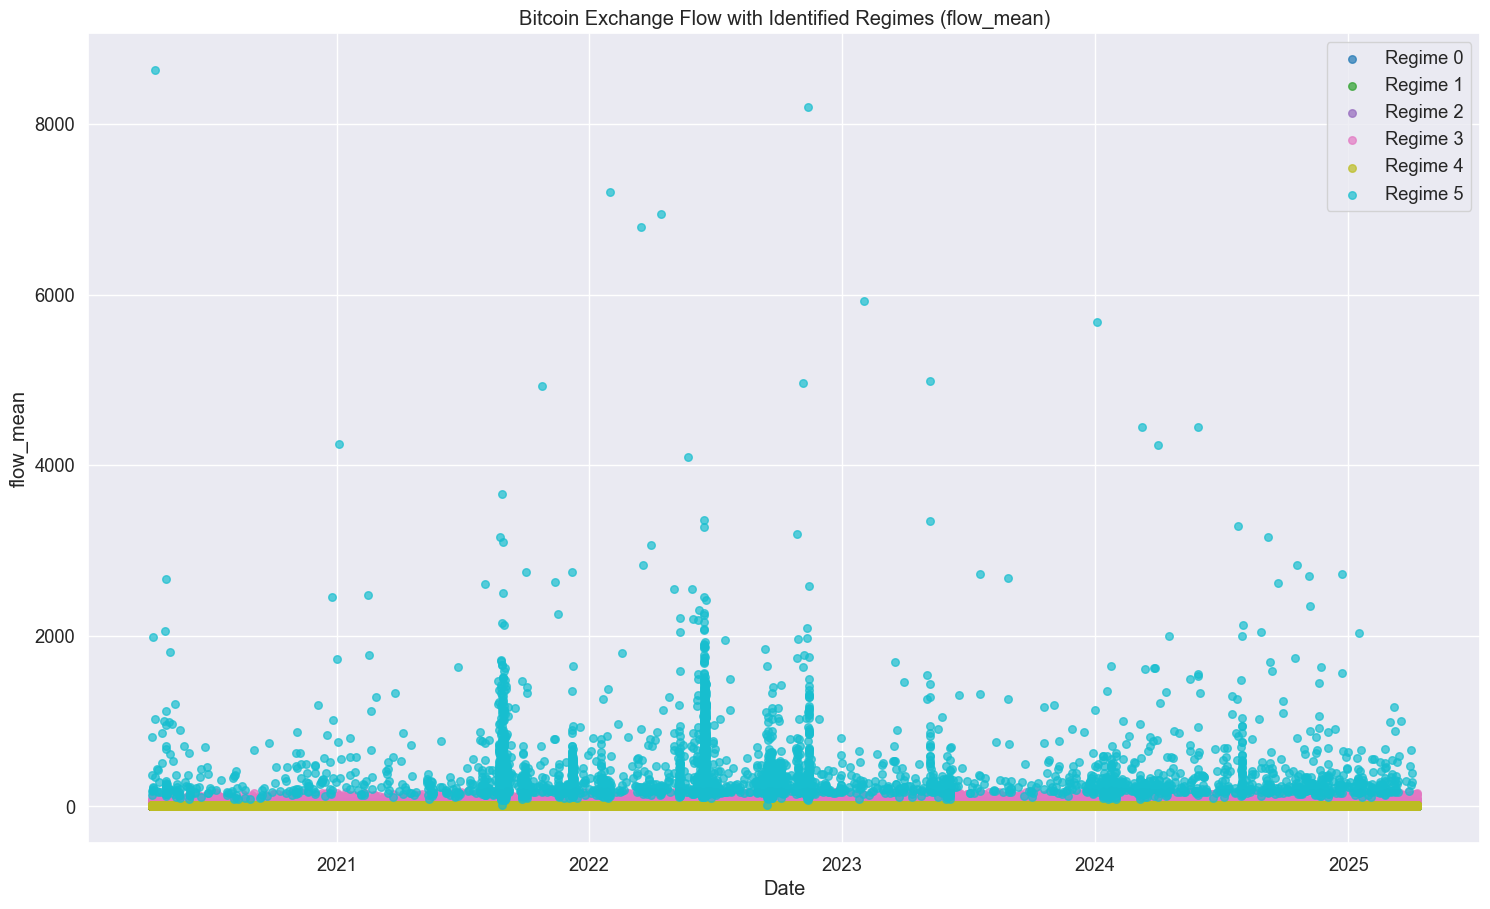

In [ ]:
#Cell 14:Visualize the identified regimes
plt.figure(figsize=(16, 10))

colors = plt.cm.tab10(np.linspace(0, 1, optimal_n_states))

for state in range(optimal_n_states):
    mask = (df['regime'] == state)
    plt.scatter(df.loc[mask, 'datetime'], 
                df.loc[mask, features[0]], 
                c=[colors[state]], 
                label=f'Regime {state}',
                alpha=0.7,
                s=30)

plt.title(f'Bitcoin Exchange Flow with Identified Regimes ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cell 15:Calculate regime statistics
regime_stats = df.groupby('regime')[features].agg(['mean', 'std', 'min', 'max'])
print("\nRegime statistics:")
print(regime_stats)


Regime statistics:
         flow_mean                                        flow_total  \
              mean         std        min          max          mean   
regime                                                                 
0        18.935131    3.954261  11.424161    31.177816   1604.932905   
1         4.551281    3.168798   0.000000    15.715918     96.311307   
2        36.387844   10.092030   0.024225    74.283724   1883.079468   
3        57.885827   40.223823   0.020076   188.465288   4113.989105   
4         8.584075    3.209076   0.003642    17.346167    585.839966   
5       417.421475  503.317082  13.840025  8635.138618  20659.349434   

                                               transactions_count_flow  \
                 std        min            max                    mean   
regime                                                                   
0         846.812628  13.684013    4500.789428               84.702813   
1          79.404314   0.000000    

In [ ]:

#Cell 16:Save the DataFrame with regimes to a CSV file

output_csv_path = r"C:\Users\User\Downloads\output_data_with_regimes.csv" 

try:
    df.to_csv(output_csv_path, index=False)
    print(f"\nDataFrame with regimes successfully saved to: {output_csv_path}")
except Exception as e:
    print(f"\nError saving DataFrame to CSV: {e}")


DataFrame with regimes successfully saved to: C:\Users\User\Downloads\output_data_with_regimes.csv


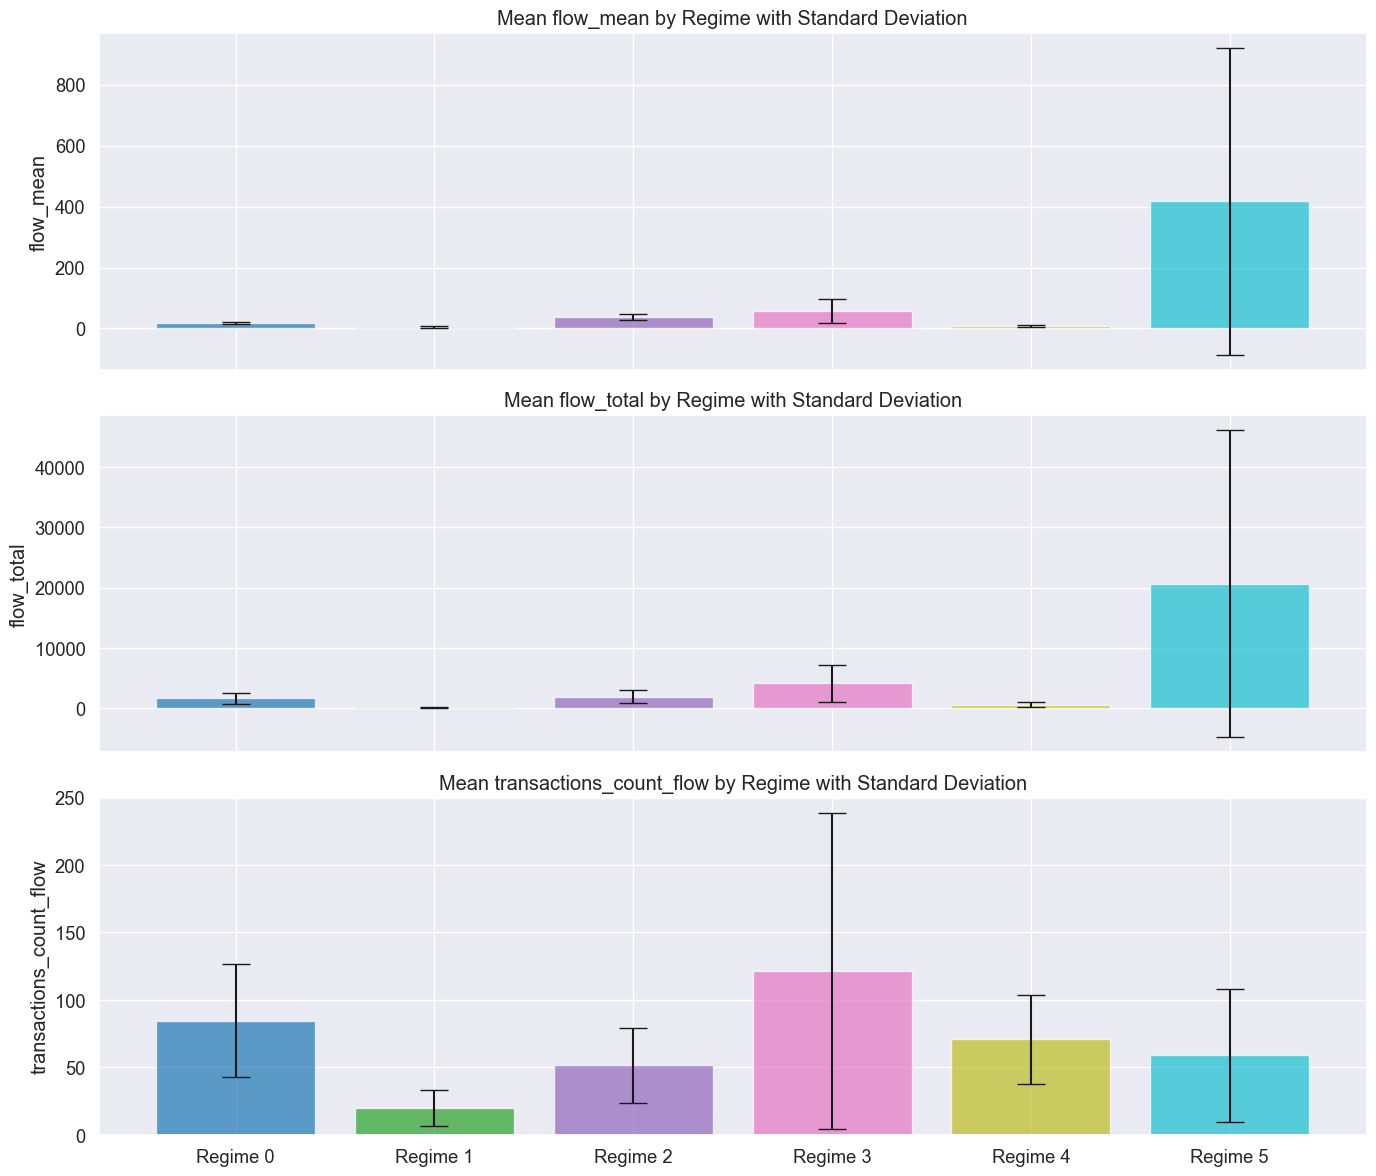

In [ ]:
#Cell 16:Plot regime characteristics
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    means = [regime_stats.loc[state, (feature, 'mean')] for state in range(optimal_n_states)]
    stds = [regime_stats.loc[state, (feature, 'std')] for state in range(optimal_n_states)]
    
    axes[i].bar(range(optimal_n_states), means, yerr=stds, capsize=10, 
              color=colors, alpha=0.7)
    axes[i].set_title(f'Mean {feature} by Regime with Standard Deviation')
    axes[i].set_ylabel(feature)
    axes[i].set_xticks(range(optimal_n_states))
    axes[i].set_xticklabels([f'Regime {state}' for state in range(optimal_n_states)])
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()


Regime transition counts:
To        0      1      2     3      4     5
From                                        
0.0   16216  10738   8053  4051  16476   488
1.0   11639  24827  10012  4444  16973  1070
2.0    8649   9928   9302  3709   7924   539
3.0    4373   3684   4014  5810   5402   452
4.0   14663  18972   8040  5121  26160   549
5.0     482    816    630   600    570  1239


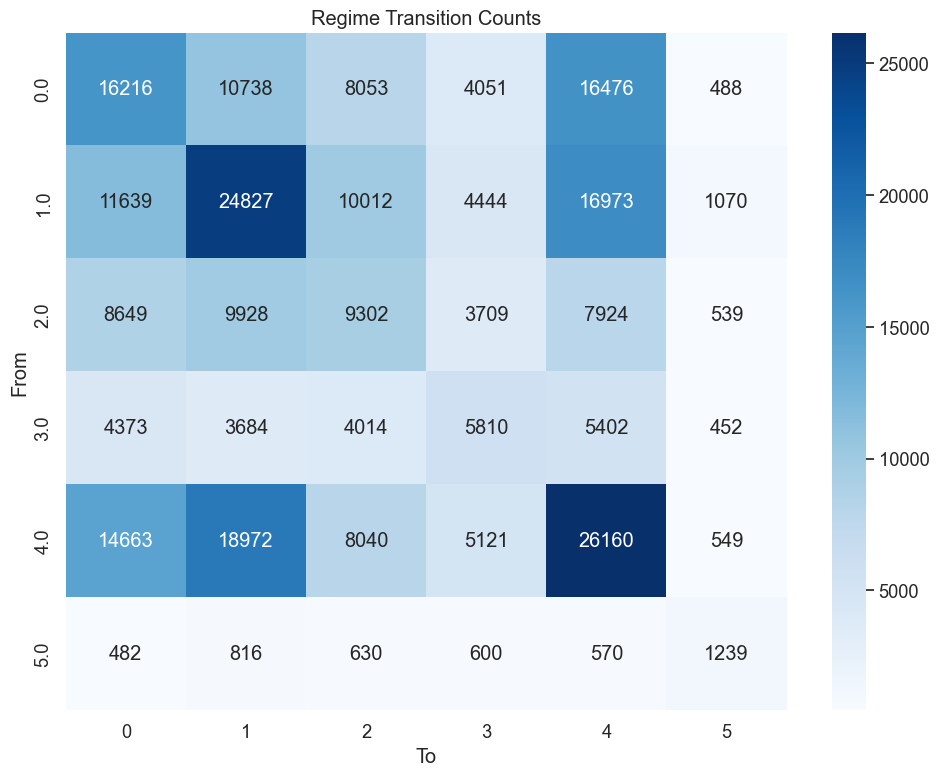

In [ ]:
#Cell 17:Analyze regime transitions
transitions = pd.crosstab(df['regime'].shift(1), df['regime'], 
                         rownames=['From'], colnames=['To'])
print("\nRegime transition counts:")
print(transitions)

plt.figure(figsize=(10, 8))
sns.heatmap(transitions, annot=True, cmap='Blues', fmt='d')
plt.title('Regime Transition Counts')
plt.tight_layout()
plt.show()


Regime transition probabilities:
To           0         1         2         3         4         5
From                                                            
0.0   0.289458  0.191675  0.143747  0.072311  0.294099  0.008711
1.0   0.168767  0.359994  0.145175  0.064438  0.246110  0.015515
2.0   0.215950  0.247884  0.232254  0.092607  0.197848  0.013458
3.0   0.184243  0.155214  0.169117  0.244786  0.227596  0.019044
4.0   0.199483  0.258105  0.109380  0.069669  0.355894  0.007469
5.0   0.111137  0.188148  0.145262  0.138344  0.131427  0.285681


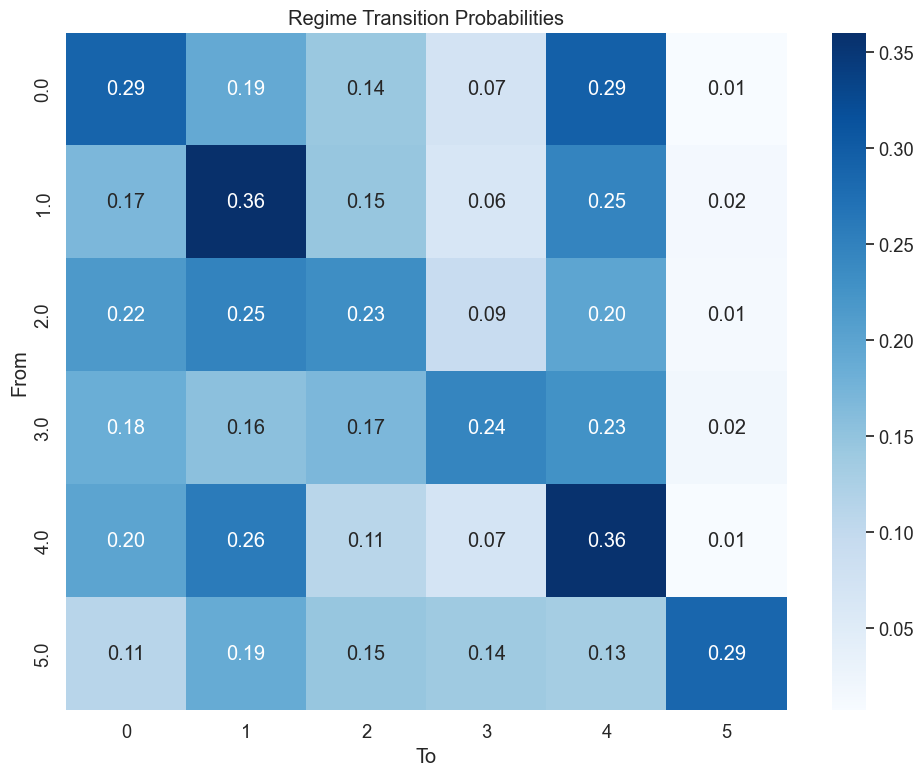

In [ ]:
#Cell 18:Calculate transition probabilities
transition_probs = transitions.div(transitions.sum(axis=1), axis=0)
print("\nRegime transition probabilities:")
print(transition_probs)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_probs, annot=True, cmap='Blues', fmt='.2f')
plt.title('Regime Transition Probabilities')
plt.tight_layout()
plt.show()

In [ ]:
#Cell 19:Analyze regime durations
regime_changes = df['regime'].diff().fillna(0) != 0
regime_start_indices = df.index[regime_changes].tolist()
regime_start_indices.append(df.index[-1])  

durations = []
regimes = []
start_dates = []
end_dates = []

for i in range(len(regime_start_indices)-1):
    start_idx = regime_start_indices[i]
    end_idx = regime_start_indices[i+1]
    
    regime = df.loc[start_idx, 'regime']
    start_date = df.loc[start_idx, 'datetime']
    end_date = df.loc[end_idx-1, 'datetime'] if end_idx > 0 else df.loc[end_idx, 'datetime']
    
    try:
        duration = (end_date - start_date).total_seconds() / (60*60*24) 
    except TypeError:
       
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        duration = (end_date - start_date).total_seconds() / (60*60*24)
    
    regimes.append(regime)
    start_dates.append(start_date)
    end_dates.append(end_date)
    durations.append(duration)

duration_df = pd.DataFrame({
    'regime': regimes,
    'start_date': start_dates,
    'end_date': end_dates,
    'duration_days': durations
})

print("\nRegime duration statistics:")
print(duration_df.groupby('regime')['duration_days'].agg(['count', 'mean', 'min', 'max']))



Regime duration statistics:
        count      mean       min       max
regime                                     
0       39806  0.004081  0.000000  0.113669
1       44138  0.001532  0.000000  0.100336
2       30749  0.002041  0.000000  0.071146
3       17925  0.003375  0.000000  0.172211
4       47345  0.004177 -0.014502  0.130486
5        3098  0.003508  0.000000  0.185174


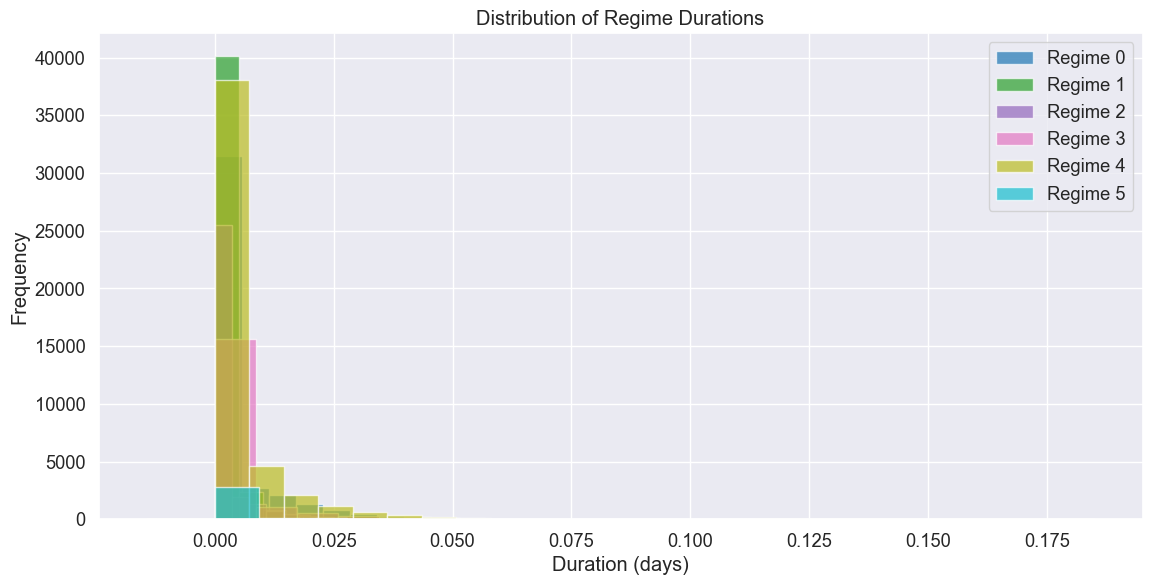

In [ ]:
#Cell 20:Plot regime durations
plt.figure(figsize=(12, 6))
for state in range(optimal_n_states):
    state_durations = duration_df[duration_df['regime'] == state]['duration_days']
    if len(state_durations) > 0:
        plt.hist(state_durations, alpha=0.7, label=f'Regime {state}', 
                bins=20, color=colors[state])

plt.title('Distribution of Regime Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cell 21:Train/test split for validation
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
dates_train, dates_test = df['datetime'][:train_size], df['datetime'][train_size:]

train_model = hmm.GaussianHMM(n_components=optimal_n_states, 
                            covariance_type='full', 
                            n_iter=100, 
                            random_state=42)
train_model.fit(X_train)
train_regimes = train_model.predict(X_train)
test_regimes = train_model.predict(X_test)

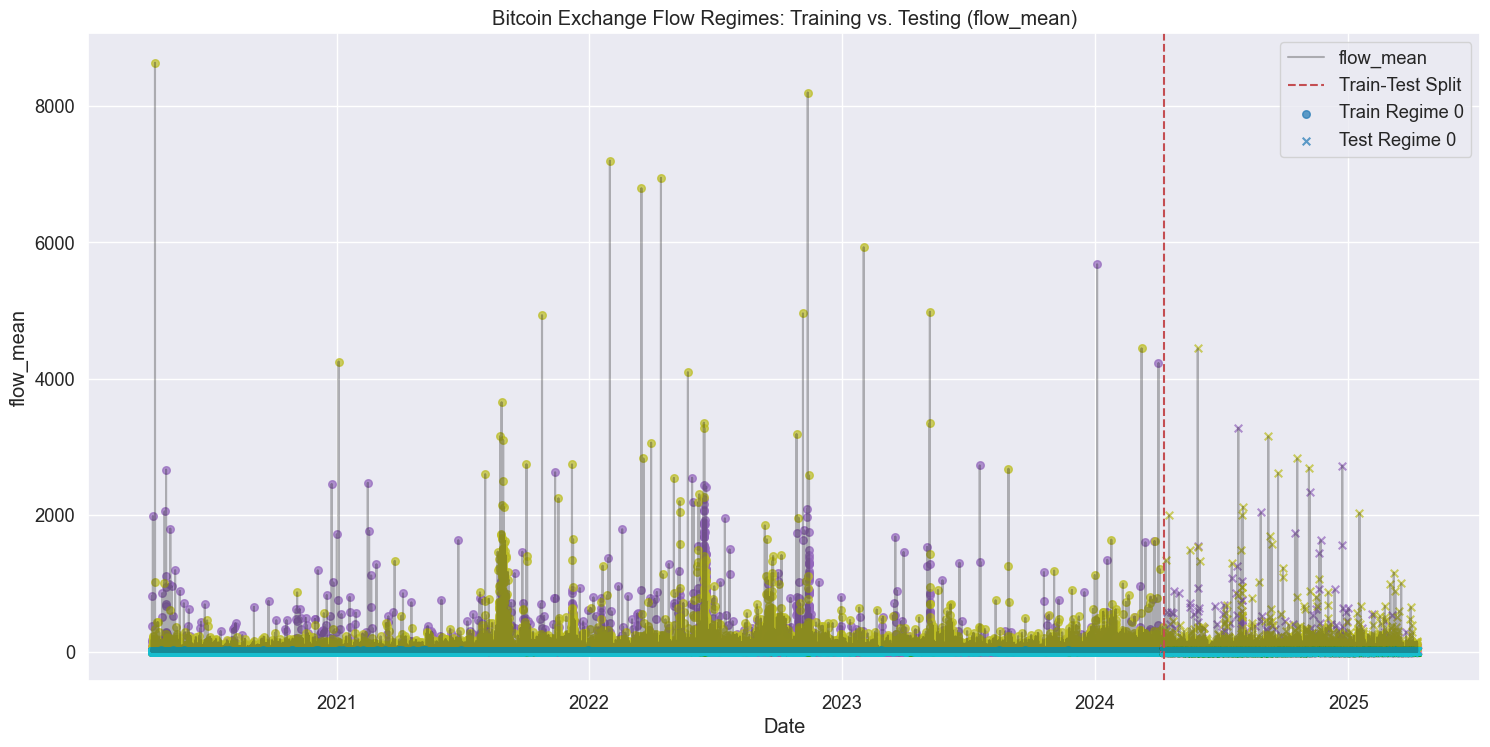

In [ ]:
#Cell 22:Visualize training and test regimes
plt.figure(figsize=(16, 8))

plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.3, label=features[0])
plt.axvline(x=dates_train.iloc[-1], color='r', linestyle='--', 
           label='Train-Test Split')

for state in range(optimal_n_states):
    mask = (train_regimes == state)
    if np.any(mask):
        plt.scatter(dates_train.iloc[mask], 
                   df[features[0]].iloc[:train_size][mask], 
                   c=[colors[state]], 
                   label=f'Train Regime {state}' if state == 0 else None,
                   alpha=0.7,
                   s=30)

for state in range(optimal_n_states):
    mask = (test_regimes == state)
    if np.any(mask):
        plt.scatter(dates_test.iloc[mask], 
                   df[features[0]].iloc[train_size:][mask], 
                   c=[colors[state]], 
                   marker='x',
                   label=f'Test Regime {state}' if state == 0 else None,
                   alpha=0.7,
                   s=30)

plt.title(f'Bitcoin Exchange Flow Regimes: Training vs. Testing ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cell 23:prediction and simulation

def simulate_future_regimes(model, current_observation, n_steps=30):
    observation = current_observation.copy()
    states = []
    observations = []
    
    random_state = np.random.RandomState(42)
    
    for _ in range(n_steps):
        state = model.predict(observation.reshape(1, -1))[0]
        states.append(state)
        
        means = model.means_[state]
        covars = model.covars_[state]
        
        next_obs = random_state.multivariate_normal(means, covars)
        observations.append(next_obs)
        observation = next_obs
    
    return states, np.array(observations)


In [ ]:
#Cell 25:Simulate future regimes
n_future_steps = 30  
last_observation = X_scaled[-1]
future_regimes, future_observations = simulate_future_regimes(model, last_observation, n_future_steps)

last_date = df['datetime'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_future_steps)

future_df = pd.DataFrame({
    'datetime': future_dates,
    'regime': future_regimes
})

future_observations_orig = scaler.inverse_transform(future_observations)
for i, feature in enumerate(features):
    future_df[feature] = future_observations_orig[:, i]


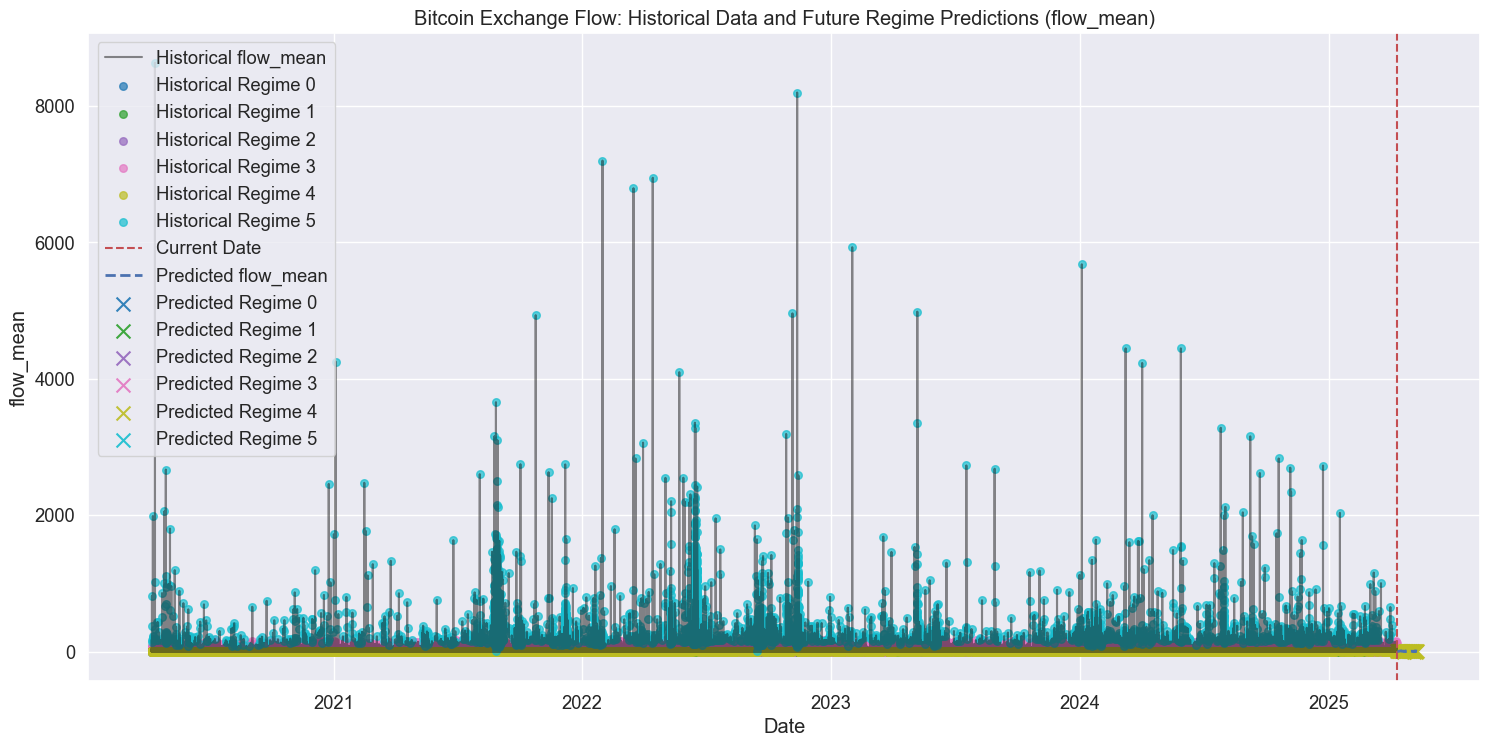

In [ ]:
#Cell 26:Visualize
plt.figure(figsize=(16, 8))

plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.5, label=f'Historical {features[0]}')

for state in range(optimal_n_states):
    mask = (df['regime'] == state)
    plt.scatter(df.loc[mask, 'datetime'], 
               df.loc[mask, features[0]], 
               c=[colors[state]], 
               label=f'Historical Regime {state}',
               alpha=0.7,
               s=30)

plt.axvline(x=last_date, color='r', linestyle='--', label='Current Date')
plt.plot(future_df['datetime'], future_df[features[0]], 'b--', linewidth=2, label=f'Predicted {features[0]}')

for state in range(optimal_n_states):
    mask = (future_df['regime'] == state)
    plt.scatter(future_df.loc[mask, 'datetime'], 
               future_df.loc[mask, features[0]], 
               c=[colors[state]], 
               marker='x',
               label=f'Predicted Regime {state}',
               alpha=0.9,
               s=100)

plt.title(f'Bitcoin Exchange Flow: Historical Data and Future Regime Predictions ({features[0]})')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Cell 27:Calculate regime chrstc
print("\nRegime interpretations:")
for state in range(optimal_n_states):
    print(f"\nRegime {state}:")
    
    feature_means = [regime_stats.loc[state, (feature, 'mean')] for feature in features]
    feature_stds = [regime_stats.loc[state, (feature, 'std')] for feature in features]
    
    for i, feature in enumerate(features):
        mean_val = feature_means[i]
        std_val = feature_stds[i]
        
        all_means = [regime_stats.loc[s, (feature, 'mean')] for s in range(optimal_n_states)]
        median_mean = np.median(all_means)
        level = "High" if mean_val > median_mean else "Low"
        
        print(f"- {level} {feature}: {mean_val:.2f} (±{std_val:.2f})")
    
    if state in transition_probs.index and state in transition_probs.columns:
        stability = transition_probs.loc[state, state]
        stability_level = "High" if stability > 0.7 else "Moderate" if stability > 0.4 else "Low"
        print(f"- {stability_level} stability (self-transition probability: {stability:.2f})")
    
    state_durations = duration_df[duration_df['regime'] == state]['duration_days']
    if len(state_durations) > 0:
        avg_duration = state_durations.mean()
        print(f"- Average duration: {avg_duration:.2f} days")
    
    frequency = (df['regime'] == state).mean() * 100
    print(f"- Frequency: {frequency:.2f}% of the time")


Regime interpretations:

Regime 0:
- Low flow_mean: 18.94 (±3.95)
- Low flow_total: 1604.93 (±846.81)
- High transactions_count_flow: 84.70 (±41.67)
- Low stability (self-transition probability: 0.29)
- Average duration: 0.00 days
- Frequency: 21.01% of the time

Regime 1:
- Low flow_mean: 4.55 (±3.17)
- Low flow_total: 96.31 (±79.40)
- Low transactions_count_flow: 19.94 (±13.27)
- Low stability (self-transition probability: 0.36)
- Average duration: 0.00 days
- Frequency: 25.87% of the time

Regime 2:
- High flow_mean: 36.39 (±10.09)
- High flow_total: 1883.08 (±1109.17)
- Low transactions_count_flow: 51.44 (±27.64)
- Low stability (self-transition probability: 0.23)
- Average duration: 0.00 days
- Frequency: 15.02% of the time

Regime 3:
- High flow_mean: 57.89 (±40.22)
- High flow_total: 4113.99 (±3070.71)
- High transactions_count_flow: 121.21 (±117.08)
- Low stability (self-transition probability: 0.24)
- Average duration: 0.00 days
- Frequency: 8.90% of the time

Regime 4:
- Low

In [ ]:
#Cell 28:Save the model
model_package = {
    'model': model,
    'scaler': scaler,
    'optimal_n_states': optimal_n_states,
    'features': features,
    'train_test_split': train_size,
    'creation_date': datetime.now().strftime('%Y-%m-%d')
}

try:
    with open('btc_exchange_flow_hmm_model_local.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    print("\nModel successfully saved to 'btc_exchange_flow_hmm_model_local.pkl'")
except Exception as e:
    print(f"\nError saving model: {e}")

print("\nHMM analysis complete!")


Model successfully saved to 'btc_exchange_flow_hmm_model_local.pkl'

HMM analysis complete!


In [ ]:
#Cell 29:Regime remap&accuracy
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment

def map_regimes(df_true, true_regimes, df_pred, pred_regimes, features):
   
    true_regime_means = {}
    pred_regime_means = {}
    
    df_true = df_true.copy()
    df_true['regime'] = true_regimes
    
    df_pred = df_pred.copy()
    df_pred['regime'] = pred_regimes

    for regime in np.unique(true_regimes):
        true_regime_means[regime] = df_true[df_true['regime'] == regime][features].mean().values
        
    for regime in np.unique(pred_regimes):
        pred_regime_means[regime] = df_pred[df_pred['regime'] == regime][features].mean().values
    
    true_regimes_unique = sorted(true_regime_means.keys())
    pred_regimes_unique = sorted(pred_regime_means.keys())
    
    cost_matrix = np.zeros((len(true_regimes_unique), len(pred_regimes_unique)))
    
    for i, true_reg in enumerate(true_regimes_unique):
        for j, pred_reg in enumerate(pred_regimes_unique):
            distance = np.linalg.norm(true_regime_means[true_reg] - pred_regime_means[pred_reg])
            cost_matrix[i, j] = distance
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    mapping = {}
    for i, j in zip(col_ind, row_ind): 
        mapping[pred_regimes_unique[i]] = true_regimes_unique[j]
        
    return mapping

def remap_regimes(regimes, mapping):
    remapped = np.array([mapping.get(r, r) for r in regimes])
    return remapped

def aligned_regime_accuracy(true_regimes, pred_regimes, df_true, df_pred, features):

    mapping = map_regimes(df_true, true_regimes, df_pred, pred_regimes, features)
    remapped_pred = remap_regimes(pred_regimes, mapping)
    accuracy = np.mean(true_regimes == remapped_pred)
    
    return accuracy, mapping, remapped_pred

In [ ]:
#Cell 30:Aligned regime accuracy
train_aligned_accuracy, train_mapping, train_remapped = aligned_regime_accuracy(
    hidden_states[:train_size], 
    train_regimes, 
    df.iloc[:train_size], 
    df.iloc[:train_size], 
    features
)

print(f"Training regime mapping: {train_mapping}")
print(f"Aligned training regime prediction accuracy: {train_aligned_accuracy:.4f}")
test_aligned_accuracy, test_mapping, test_remapped = aligned_regime_accuracy(
    hidden_states[train_size:], 
    test_regimes, 
    df.iloc[train_size:], 
    df.iloc[train_size:], 
    features
)

print(f"Test regime mapping: {test_mapping}")
print(f"Aligned test regime prediction accuracy: {test_aligned_accuracy:.4f}")


Training regime mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(2): np.int64(5)}
Aligned training regime prediction accuracy: 0.6783
Test regime mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(2): np.int64(5)}
Aligned test regime prediction accuracy: 0.7483


In [ ]:
#Cell 31:Calculate cluster evaluation metrics
train_ari = adjusted_rand_score(hidden_states[:train_size], train_regimes)
train_nmi = normalized_mutual_info_score(hidden_states[:train_size], train_regimes)
train_ami = adjusted_mutual_info_score(hidden_states[:train_size], train_regimes)

print("Training data cluster evaluation metrics:")
print(f"Adjusted Rand Index: {train_ari:.4f}")
print(f"Normalized Mutual Information: {train_nmi:.4f}")
print(f"Adjusted Mutual Information: {train_ami:.4f}")

test_ari = adjusted_rand_score(hidden_states[train_size:], test_regimes)
test_nmi = normalized_mutual_info_score(hidden_states[train_size:], test_regimes)
test_ami = adjusted_mutual_info_score(hidden_states[train_size:], test_regimes)

print("\nTest data cluster evaluation metrics:")
print(f"Adjusted Rand Index: {test_ari:.4f}")
print(f"Normalized Mutual Information: {test_nmi:.4f}")
print(f"Adjusted Mutual Information: {test_ami:.4f}")

Training data cluster evaluation metrics:
Adjusted Rand Index: 0.4445
Normalized Mutual Information: 0.5392
Adjusted Mutual Information: 0.5392

Test data cluster evaluation metrics:
Adjusted Rand Index: 0.5856
Normalized Mutual Information: 0.5990
Adjusted Mutual Information: 0.5989


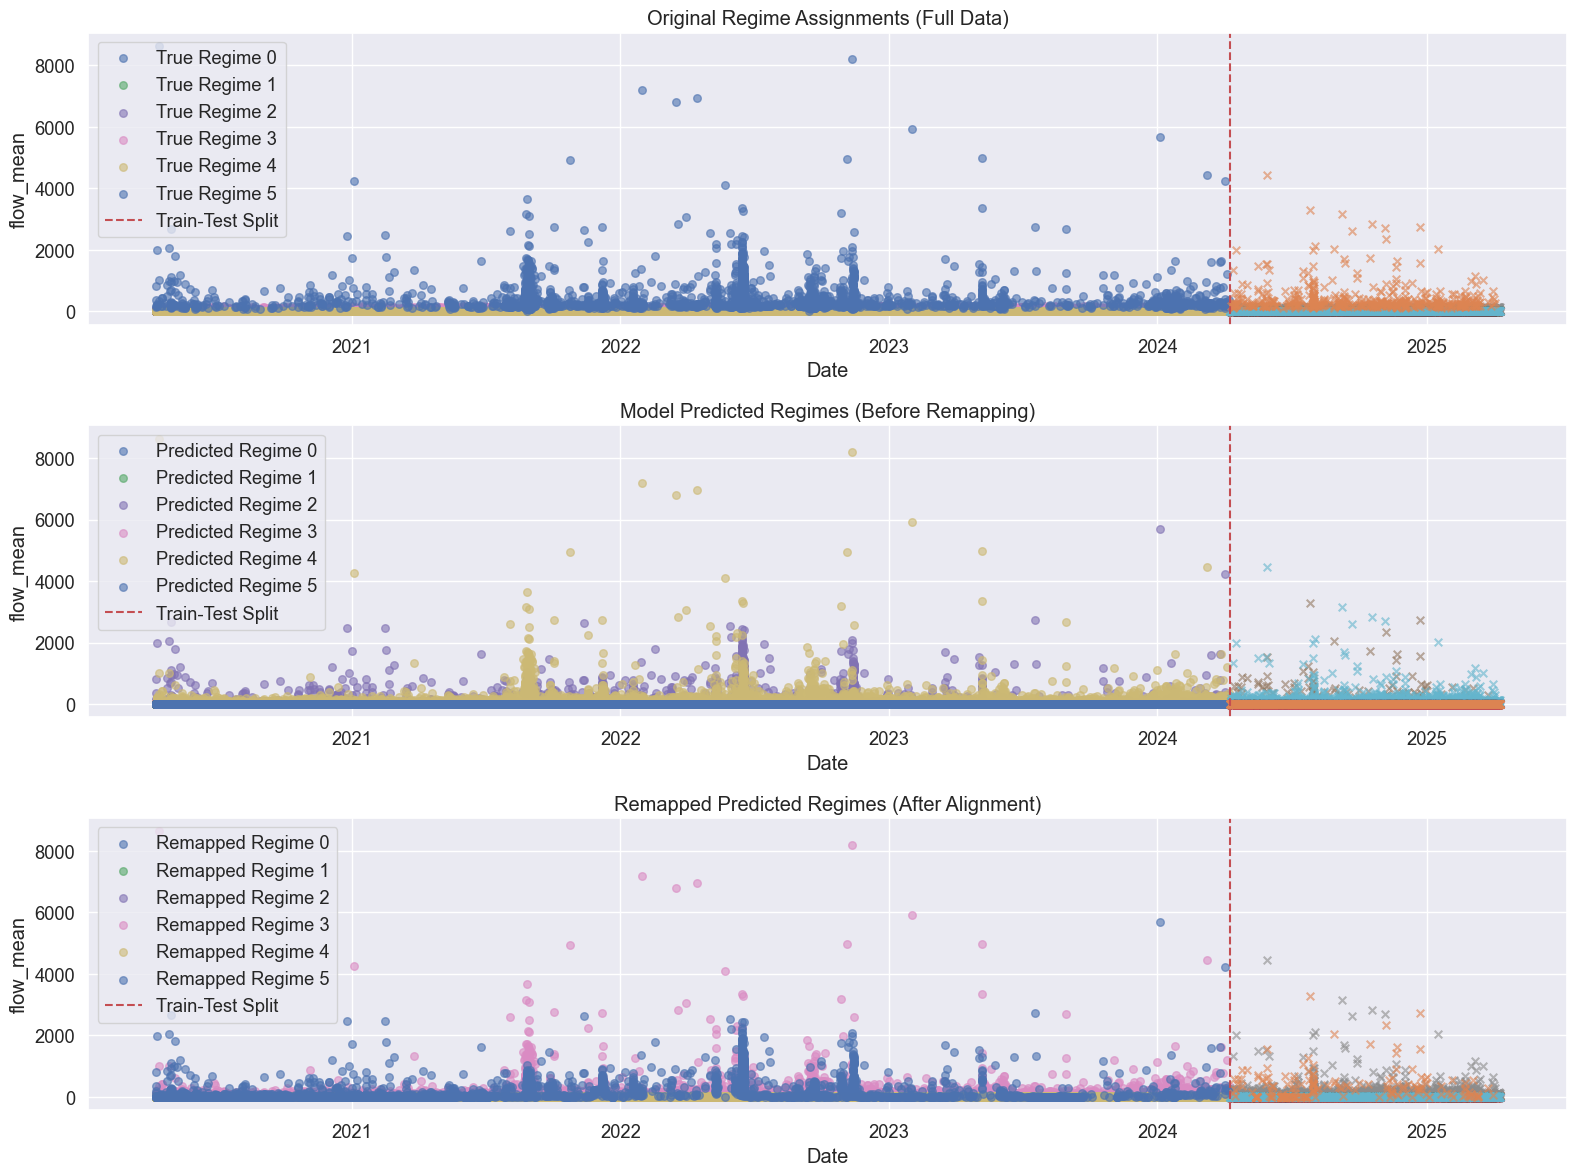

In [ ]:
#Cell 32:Visualize original, predicted, and remapped regimes
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
for state in range(optimal_n_states):
    mask_train = (hidden_states[:train_size] == state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'True Regime {state}')
    
    mask_test = (hidden_states[train_size:] == state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Original Regime Assignments (Full Data)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
for state in range(optimal_n_states):
    mask_train = (train_regimes==state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'Predicted Regime {state}')
    
    mask_test = (test_regimes==state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Model Predicted Regimes (Before Remapping)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
for state in range(optimal_n_states):
    mask_train = (train_remapped == state)
    if np.any(mask_train):
        plt.scatter(df.iloc[:train_size].loc[mask_train, 'datetime'], 
                    df.iloc[:train_size].loc[mask_train, features[0]], 
                    s=30, alpha=0.6, label=f'Remapped Regime {state}')
    
    mask_test = (test_remapped == state)
    if np.any(mask_test):
        plt.scatter(df.iloc[train_size:].loc[mask_test, 'datetime'], 
                    df.iloc[train_size:].loc[mask_test, features[0]], 
                    s=30, alpha=0.6, marker='x')

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', label='Train-Test Split')
plt.title('Remapped Predicted Regimes (After Alignment)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Cell 33:Analyze transition accuracy
def identify_transitions(regimes):
    """Returns indices where regime transitions occur"""
    changes = np.diff(regimes) != 0
    change_indices = np.where(changes)[0] + 1  
    return change_indices

true_train_transitions = identify_transitions(hidden_states[:train_size])
pred_train_transitions = identify_transitions(train_remapped)

true_test_transitions = identify_transitions(hidden_states[train_size:])
pred_test_transitions = identify_transitions(test_remapped)

def transition_detection_accuracy(true_transitions, pred_transitions, tolerance=5):
    true_positives = 0
    
    for true_idx in true_transitions:
        if any(abs(true_idx - pred_idx) <= tolerance for pred_idx in pred_transitions):
            true_positives += 1
    precision = true_positives / len(pred_transitions) if len(pred_transitions) > 0 else 0
    recall = true_positives / len(true_transitions) if len(true_transitions) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

train_prec, train_rec, train_f1 = transition_detection_accuracy(true_train_transitions, pred_train_transitions)
test_prec, test_rec, test_f1 = transition_detection_accuracy(true_test_transitions, pred_test_transitions)

print("Regime Transition Detection (Training Data):")
print(f"Precision: {train_prec:.4f} ")
print(f"Recall: {train_rec:.4f} ")
print(f"F1 Score: {train_f1:.4f} ")

print("\nRegime Transition Detection (Test Data):")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Regime Transition Detection (Training Data):
Precision: 1.0662 (% of predicted transitions that are correct)
Recall: 0.9993 (% of actual transitions that were detected)
F1 Score: 1.0316 (harmonic mean of precision and recall)

Regime Transition Detection (Test Data):
Precision: 1.1306
Recall: 0.9937
F1 Score: 1.0578


In [ ]:
#Cell 34:Visualize transitions
plt.figure(figsize=(16, 8))
plt.plot(df['datetime'], df[features[0]], 'k-', alpha=0.3, label=features[0])

plt.axvline(x=df.iloc[train_size-1]['datetime'], color='r', linestyle='--', 
           label='Train-Test Split')
for idx in true_train_transitions:
    plt.axvline(x=df.iloc[idx]['datetime'], color='blue', alpha=0.5, linewidth=1)
for idx in true_test_transitions:
    plt.axvline(x=df.iloc[train_size + idx]['datetime'], color='blue', alpha=0.5, linewidth=1)
for idx in pred_train_transitions:
    plt.axvline(x=df.iloc[idx]['datetime'], color='green', alpha=0.5, linewidth=1, linestyle=':')
for idx in pred_test_transitions:
    plt.axvline(x=df.iloc[train_size + idx]['datetime'], color='green', alpha=0.5, linewidth=1, linestyle=':')

plt.title('Regime Transitions: True (Blue) vs Predicted (Green)')
plt.xlabel('Date')
plt.ylabel(features[0])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def merge_csv_files():
    # Read the CSV files
    print("Reading CSV files...")
    df1 = pd.read_csv('regime_analysis_latest.csv')
    df2 = pd.read_csv('merged_bitcoin_data.csv')
    
    # Display the columns in each dataframe
    print("\nColumns in regime_analysis_latest_latest.csv:")
    print(df1.columns.tolist())
    print("\nColumns in merged_metrics.csv:")
    print(df2.columns.tolist())
    
    
    # Identify common columns to merge on
    common_columns = ['flow_mean', 'flow_total', 'transaction_flow_count', 'datetime']
    
    # Ensure datetime is in the same format in both dataframes
    df1['datetime'] = pd.to_datetime(df1['datetime'])
    df2['datetime'] = pd.to_datetime(df2['datetime'])
    
    # Merge the dataframes on datetime
    print("\nMerging dataframes...")
    merged_df = pd.merge(df1, df2, on='datetime', how='outer', suffixes=('_1', '_2'))
    
    # Combine the identical columns
    for col in ['flow_mean', 'flow_total', 'transaction_flow_count']:
        col1 = f"{col}_1"
        col2 = f"{col}_2"
        if col1 in merged_df.columns and col2 in merged_df.columns:
            # Use values from df1 if available, otherwise use df2
            merged_df[col] = merged_df[col1].fillna(merged_df[col2])
            # Drop the temporary columns
            merged_df = merged_df.drop([col1, col2], axis=1)
    
    # Display the merged dataframe info
    print("\nMerged dataframe shape:", merged_df.shape)
    print("\nMerged dataframe columns:")
    print(merged_df.columns.tolist())
    
    # Save the merged dataframe to a new CSV file
    print("\nSaving merged data...")
    merged_df.to_csv('final_merged_data.csv', index=False)
    print("Merged data saved to 'final_merged_data.csv'")

if __name__ == "__main__":
    merge_csv_files() 